## Group Project Report - Algerian Forest Fires
Ivena Du, Serena Szeto, Sophie Song, Ella Chan

In [56]:
library(tidyverse)
library(repr)
library(GGally)
library(broom)
options(repr.matrix.max.rows = 6)
set.seed(3456) 

### Introduction:

### Methods and Results:

### Code:

#### 1) Data was loaded in from the web to R.

In [57]:
forest_fire_data_raw <- read.csv("https://archive.ics.uci.edu/ml/machine-learning-databases/00547/Algerian_forest_fires_dataset_UPDATE.csv", skip = 1)

#### 2) Wrangling and Cleaning the Data.
* The data is not in a tidy form as the data actually contains two regions of observations. Rows 1-122 are observations for the Bejaia Region, while rows 125 to 246 are for the Sidi-Bel Abbes Region (rows 123 and 124 contain column headers). To tidy this, an extra column called "region" will be created. After this all observations will be tidy, as they are split into individual rows, each column is a single variable and each value is in a single cell.
* We also noticed that for the 14/07/2012 data point (row 166 for the forest_fire_data_tidy dataframe) in the Sidi-Bel Abbes Region, the original dataset had a typo in it, where they forgot the delim between the ISI and BUI columns. To fix this, we removed that datapoint and replaced it with one that is correctly written (but did not change the values).
* Additionally, to make the data more usable, we decided to convert some of the columns from characters to factors (Classes) and numeric values (Temperature:FWI).
* Finally, we split the data into a 75% training and 25% testing set. We chose this split data in this way as our data set is quite small, and therefore we had to have an uneven split.

In [68]:
forest_fire_data_collect <- collect(forest_fire_data_raw) # We first collected the tables from the web to be able to work with them more easily.

forest_fire_data_bejaia <- forest_fire_data_collect %>% # We then seperated out the Bejaia Region and created a new "regions" column.
    slice(1:122) %>%
    mutate(region = "Bejaia")

forest_fire_data_sidibel <- forest_fire_data_collect %>% # We then seperated out the Sidi-Bel Abbes Region and created a new "regions" column.
    slice(125:246) %>%
    mutate(region = "Sidi-Bel_Abbes")

forest_fire_data_tidy <- rbind(forest_fire_data_bejaia,forest_fire_data_sidibel) # Combining the two tables produced above.

forest_fire_fix <- forest_fire_data_tidy %>% # Fixing the broken row for 14/07/2012 observation.
    slice(-166) %>%
    add_row(day = "14", month = "07", year = "2012", Temperature = "37",RH = "37",Ws = "18",Rain = "0.2",FFMC = "88.9",DMC = "12.9",DC = "14.6",ISI = "9", BUI = "12.5", FWI = "10.4", Classes = "fire",region = "Sidi-Bel_Abbes")

forest_fire_data_mutated <- forest_fire_fix %>% # Mutating the numeric values into as.numerics. 
    mutate(Temperature = as.numeric(Temperature),
           RH = as.numeric(RH),
           Ws = as.numeric(Ws),
           Rain = as.numeric(Rain),
           FFMC = as.numeric(FFMC),
           DMC = as.numeric(DMC),
           DC = as.numeric(DC),
           ISI = as.numeric(ISI),
           BUI = as.numeric(BUI),
           FWI = as.numeric(FWI))

forest_fire_categories <- forest_fire_data_mutated %>% # Grouping the Classes column into just "fire" and "not fire." Converting the Classes column into a factor.
    mutate(Classes = ifelse(Classes == "fire" | Classes == "fire   " | Classes == "fire "| Classes == "fire  "|Classes == "fire   ", "fire", "not fire")) %>%
    mutate(Classes = as.factor(Classes))

##### Table 1. Cleaned Forest Fire Data

In [67]:
forest_fire_categories

day,month,year,Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,FWI,Classes,region
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>
01,06,2012,29,57,18,0.0,65.7,3.4,7.6,1.3,3.4,0.5,not fire,Bejaia
02,06,2012,29,61,13,1.3,64.4,4.1,7.6,1.0,3.9,0.4,not fire,Bejaia
03,06,2012,26,82,22,13.1,47.1,2.5,7.1,0.3,2.7,0.1,not fire,Bejaia
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
29,09,2012,24,54,18,0.1,79.7,4.3,15.2,1.7,5.1,0.7,not fire,Sidi-Bel_Abbes
30,09,2012,24,64,15,0.2,67.3,3.8,16.5,1.2,4.8,0.5,not fire,Sidi-Bel_Abbes
14,07,2012,37,37,18,0.2,88.9,12.9,14.6,9.0,12.5,10.4,fire,Sidi-Bel_Abbes


In [59]:
# 75% of the data was used as training data in this analysis

forest_split <- initial_split(forest_fire_categories,
                              prop = 0.75,
                              strata = Classes) # Splitting the data with 75% for training and 25% for testing.
forest_fire_training <- training(forest_split)   
forest_fire_testing <- testing(forest_split)

#### 3) Summary of Data Set for Exploratory Analysis:
* We decided to summarize the mean values of the temperature, realtive humidity, wind speed and rain columns to investigate what magnitude of values each variable was in. !!!
* We also summarized the total number of observations in each class to explore the way the training data was split.

In [60]:
forest_fire_summary <- forest_fire_training %>% 
    summarize(mean_temperature = mean(Temperature), # Computing the means of the predictors.
              mean_rh = mean(RH),
              mean_ws = mean(Ws),
              mean_rain = mean(Rain)) %>%
    mutate(total_number_of_observations = nrow(forest_fire_training)) %>% # Counting the total number of observations used in the training data set.
    mutate(fire_number_of_observations = nrow(filter(forest_fire_training, Classes == "fire"))) %>% # Counting the number of fire observations used in the training data set.
    mutate(not_fire_number_of_observations = total_number_of_observations - fire_number_of_observations) # Computing the number of not fire observations used in the training data set.

forest_fire_summary

mean_temperature,mean_rh,mean_ws,mean_rain,total_number_of_observations,fire_number_of_observations,not_fire_number_of_observations
<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>
32.16304,62.26087,15.65217,0.736413,184,104,80


#### 4) Visualizations of Data Set for Exploratory Analysis:
* We decided to create histograms of each variable to visually determine which variables are able to differentiate from fire and non-fire classes.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



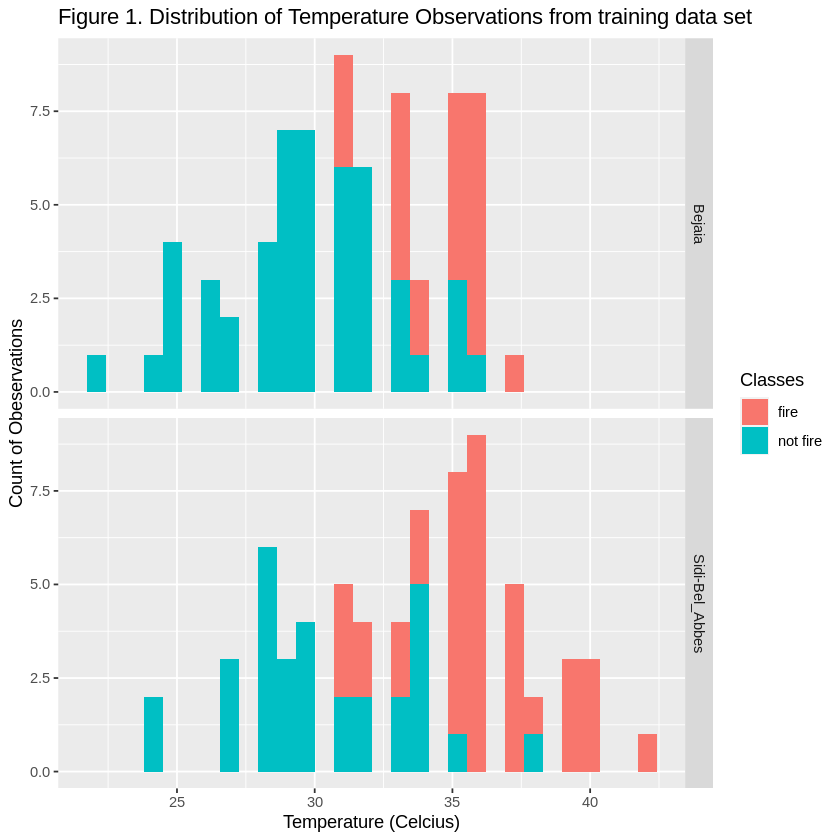

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



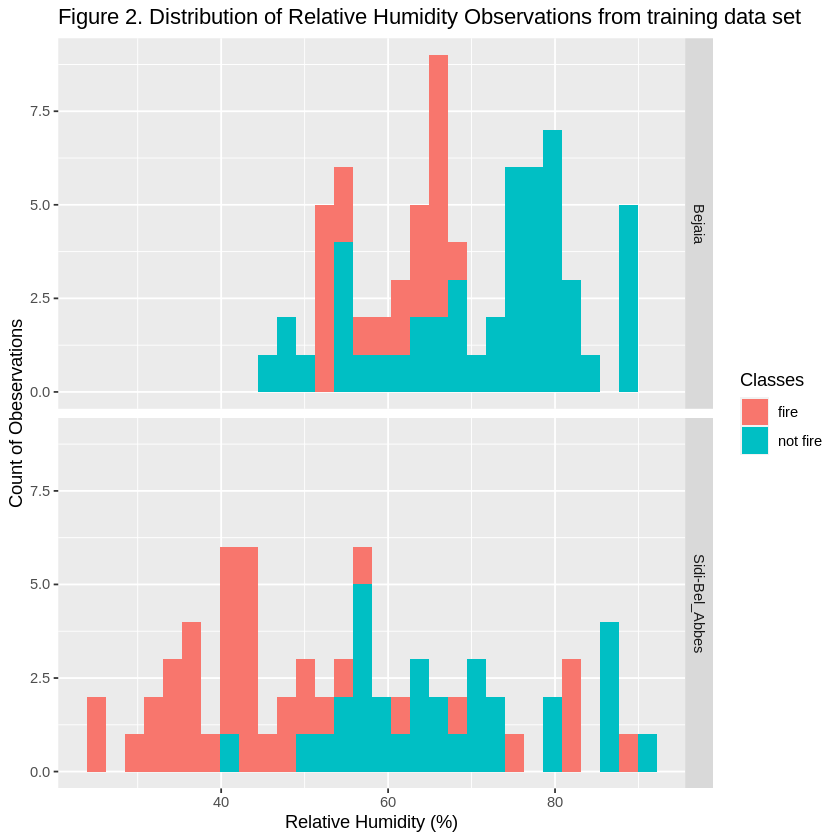

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



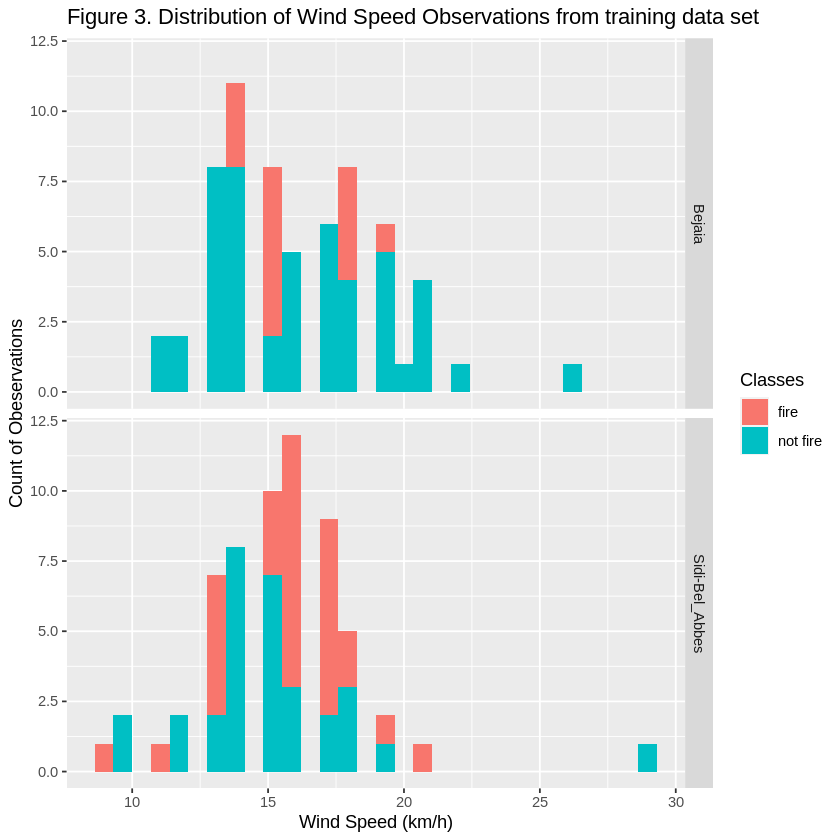

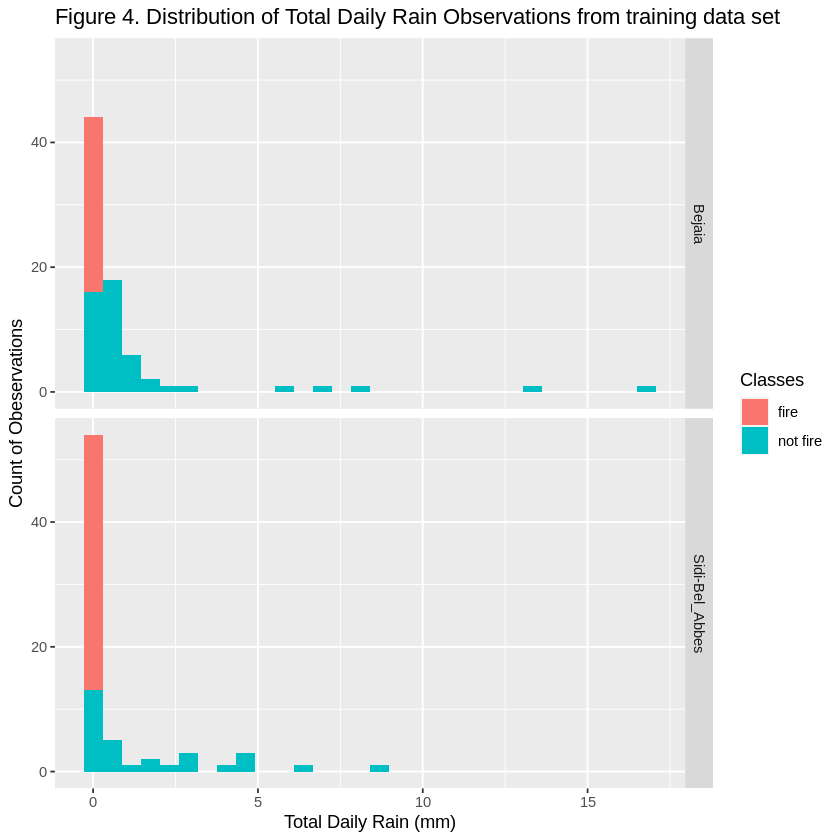

In [61]:
forest_fire_visualization_temperature <- forest_fire_training %>%
    ggplot(aes(x = Temperature, fill = Classes)) +
    facet_grid(region ~ .) +
    geom_histogram(position = "identity") +
    labs(x = "Temperature (Celcius)", y = "Count of Obeservations",
         title = "Figure 1. Distribution of Temperature Observations from training data set")

forest_fire_visualization_temperature

forest_fire_visualization_RH <- forest_fire_training %>%
    ggplot(aes(x = RH, fill = Classes)) +
    facet_grid(region ~ .) +
    geom_histogram(position = "identity") +
    labs(x = "Relative Humidity (%)", y = "Count of Obeservations",
         title = "Figure 2. Distribution of Relative Humidity Observations from training data set")

forest_fire_visualization_RH

forest_fire_visualization_Ws <- forest_fire_training %>%
    ggplot(aes(x = Ws, fill = Classes)) +
    facet_grid(region ~ .) +
    geom_histogram(position = "identity") +
    labs(x = "Wind Speed (km/h)", y = "Count of Obeservations",
         title = "Figure 3. Distribution of Wind Speed Observations from training data set")

forest_fire_visualization_Ws

forest_fire_visualization_Rain <- forest_fire_training %>%
    ggplot(aes(x = Rain, fill = Classes)) +
    facet_grid(region ~ .) +
    geom_histogram(position = "identity") +
    labs(x = "Total Daily Rain (mm)", y = "Count of Obeservations",
         title = "Figure 4. Distribution of Total Daily Rain Observations from training data set")

forest_fire_visualization_Rain

#### 5) Performing the Data Analysis
* We decided to use k-nearest neighbours classification for this report, as we wanted to see if we could classify conditions as "fire" or "non-fire" conditions.
* We used a 10 fold cross-validation to explore the data, as we wanted to ensure that K-values produced were the most accurate. !!!

In [62]:
knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
    set_engine("kknn") %>%
    set_mode("classification")

fire_recipe <- recipe(Classes ~ Temperature + Rain, data = forest_fire_training) %>%
    step_scale(all_predictors())%>%
    step_center(all_predictors())

fire_vfold <- vfold_cv(forest_fire_training, v = 10, strata = Classes)

fire_results <- workflow() %>%
    add_recipe(fire_recipe) %>%
    add_model(knn_tune) %>%
    tune_grid(resamples = fire_vfold, grid = 20) %>%
    collect_metrics()

fire_results

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.8640351,10,0.01462151,Model01
1,roc_auc,binary,0.8619318,10,0.01506819,Model01
2,accuracy,binary,0.8807018,10,0.01311849,Model02
⋮,⋮,⋮,⋮,⋮,⋮,⋮
14,roc_auc,binary,0.9205114,10,0.01481067,Model14
15,accuracy,binary,0.8315789,10,0.02302424,Model15
15,roc_auc,binary,0.9185795,10,0.01448017,Model15


* We then plotted the data and pulled the K with the highest level of accuracy.

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
2,accuracy,binary,0.8807018,10,0.01311849,Model02


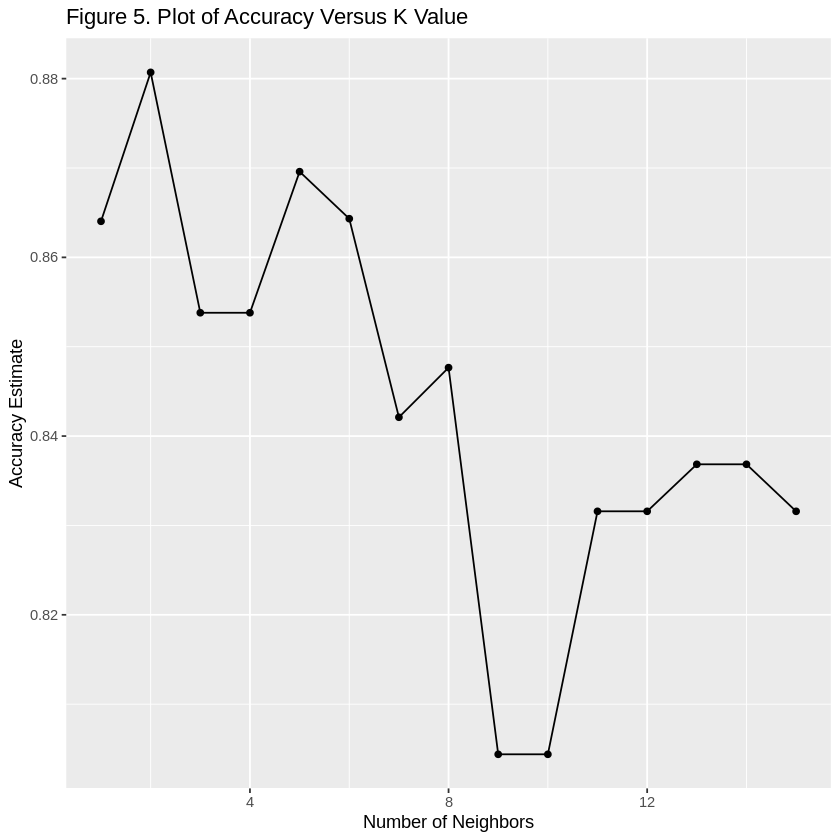

In [63]:
accuracies <- fire_results %>%
    filter(.metric == "accuracy")

accuracy_versus_k <- accuracies %>%
                     ggplot(aes(x = neighbors, y = mean)) +
                     geom_point() +
                     geom_line() +
                     labs(x = "Number of Neighbors", y = "Accuracy Estimate", title = "Figure 5. Plot of Accuracy Versus K Value")
accuracy_versus_k

best_estimate <- accuracies %>%
          arrange(desc(mean)) %>%
          slice(1)
best_estimate

In [64]:
best_k <- best_estimate %>%
          pull(neighbors)

fire_best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = best_k) %>%
    set_engine("kknn") %>%
    set_mode("classification")

fire_best_fit <- workflow() %>%
    add_recipe(fire_recipe) %>%
    add_model(fire_best_spec) %>%
    fit(data = forest_fire_training)

fire_test_result <- fire_best_fit %>%
    predict(forest_fire_testing) %>%
    bind_cols(forest_fire_testing)

fire_test_result

fire_summary <- fire_test_result %>%
    metrics(truth = Classes, estimate = .pred_class)

fire_summary

.pred_class,day,month,year,Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,FWI,Classes,region
<fct>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>
not fire,02,06,2012,29,61,13,1.3,64.4,4.1,7.6,1.0,3.9,0.4,not fire,Bejaia
not fire,14,06,2012,30,78,20,0.5,59.0,4.6,7.8,1.0,4.4,0.4,not fire,Bejaia
not fire,22,06,2012,31,67,17,0.1,79.1,7.0,39.5,2.4,9.7,2.3,not fire,Bejaia
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
fire,22,09,2012,33,64,13,0,88.9,26.1,106.3,7.1,32.4,13.7,fire,Sidi-Bel_Abbes
not fire,24,09,2012,26,49,6,2,61.3,11.9,28.1,0.6,11.9,0.4,not fire,Sidi-Bel_Abbes
fire,26,09,2012,30,65,14,0,85.4,16.0,44.5,4.5,16.9,6.5,fire,Sidi-Bel_Abbes


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.8000000
kap,binary,0.5964126


#### 6) Visualizing the Data Analysis

In [65]:
rain_grid <- seq(min(forest_fire_categories$Rain), max(forest_fire_categories$Rain), length.out = 100)

temperature_grid <- seq(min(forest_fire_categories$Temperature), max(forest_fire_categories$Temperature), length.out = 100)

asgrid <- as_tibble(expand.grid(Rain = rain_grid, Temperature = temperature_grid))

pred_grid <- predict(fire_best_fit, asgrid)

prediction_table <- bind_cols(pred_grid, asgrid)

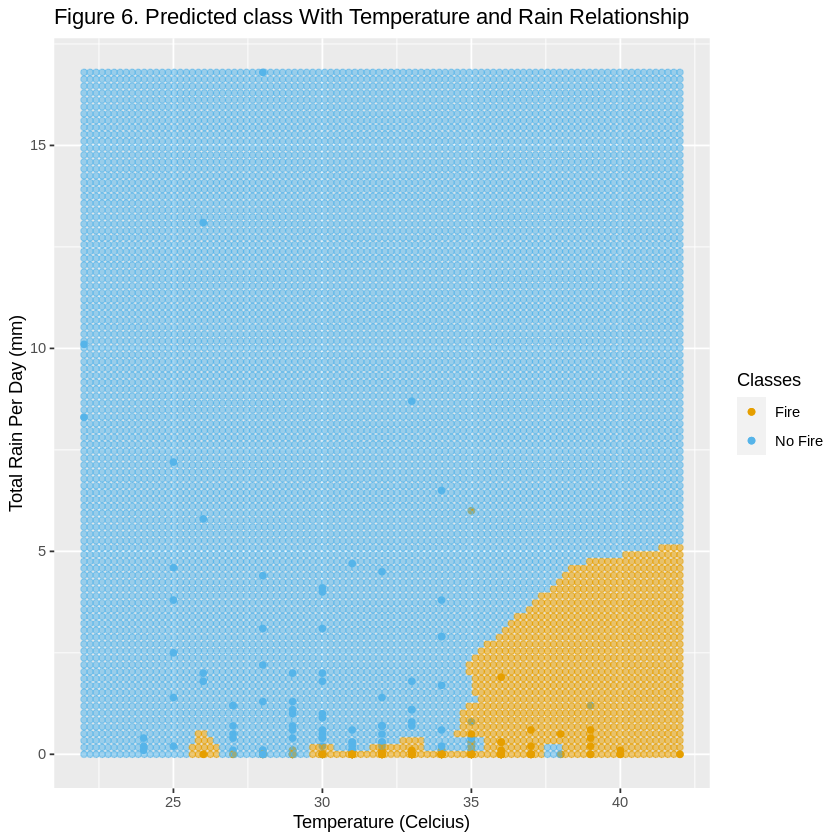

In [66]:
# temp_ws_plot_r <- fire_test_result %>%
#                 ggplot(aes(x = Temperature, y = Ws)) +
#                 geom_point(aes(color = Classes)) +
#                 geom_raster(aes(fill = .pred_class, alpha = 0.5))
 
# temp_ws_plot_r
# temp_ws_plot_t <- fire_test_result %>%
#                 ggplot(aes(x = Temperature, y = Ws)) +
#                 geom_point(aes(color = Classes)) +
#                 geom_tile(aes(fill = .pred_class, alpha = 0.5))

# temp_ws_plot_t

cbPalette <- c("#E69F00", "#56B4E9", "#009E73")

temp_rain_plot_r <- ggplot() +
                geom_point(data = forest_fire_categories, mapping = aes(x = Temperature, y = Rain, colour = Classes)) + 
                geom_point(data = prediction_table, mapping = aes(x = Temperature, y = Rain, colour = .pred_class, alpha = 0.1)) +
                scale_color_manual(labels = c("Fire", "No Fire"), values = cbPalette) +
                labs(x = "Temperature (Celcius)", y = "Total Rain Per Day (mm)", title = "Figure 6. Predicted class With Temperature and Rain Relationship") +
                guides(alpha=FALSE)
temp_rain_plot_r

### Discussion:

### References: